<a href="https://colab.research.google.com/github/kcalizadeh/phil_nlp/blob/master/neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and Mounting Drive

In [10]:
# this cell mounts drive, sets the correct directory, then imports all functions
# and relevant libraries via the functions.py file
from google.colab import drive
import sys

# install relevent libraries not included with colab
!pip install lime
!pip install symspellpy

drive.mount('/gdrive',force_remount=True)

drive_path = '/gdrive/MyDrive/Colab_Projects/Phil_NLP'

sys.path.append(drive_path)

Mounted at /gdrive


In [11]:
%load_ext autoreload
%autoreload 2
from functions import *

np.random.seed(17)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load the Data

In [12]:
df = pd.read_csv('/gdrive/MyDrive/Colab_Projects/Phil_NLP/phil_nlp.csv')

df.sample(5)

,title,author,school,sentence_spacy,sentence_str,sentence_length,sentence_lowered,lemmatized_str,tokenized_txt
48450,complete works vol 1,Aristotle,aristotle,"And this is true in every category, whether th...","And this is true in every category, whether th...",132,"and this is true in every category, whether th...","and this be true in every category , whether ...","['And', 'this', 'is', 'true', 'in', 'every', '..."
236307,being and time,Heidegger,phenomenology,But this existential interpretation is necessa...,But this existential interpretation is necessa...,284,but this existential interpretation is necessa...,but this existential interpretation be necess...,"['But', 'this', 'existential', 'interpretation..."
117613,search after truth,Malebranche,rationalism,"Rather it should become its judge and master, ...","Rather it should become its judge and master, ...",116,"rather it should become its judge and master, ...",rather -PRON- should become -PRON- judge and ...,"['Rather', 'it', 'should', 'become', 'its', 'j..."
72251,complete works vol 2,Aristotle,aristotle,"This sort of having, then, evidently we cannot...","This sort of having, then, evidently we cannot...",137,"this sort of having, then, evidently we cannot...","this sort of have , then , evidently -PRON- c...","['This', 'sort', 'of', 'having', ',', 'then', ..."
70656,complete works vol 2,Aristotle,aristotle,"Again, it will not be possible to construct a ...","Again, it will not be possible to construct a ...",67,"again, it will not be possible to construct a ...","again , -PRON- will not be possible to constr...","['Again', ',', 'it', 'will', 'not', 'be', 'pos..."


### Build a Baseline LSTM Model

In [14]:
# make the labels numerical
school_label_dict = {'analytic': 0,
 'aristotle': 1,
 'capitalism': 2,
 'communism': 3,
 'continental': 4,
 'empiricism': 5,
 'german_idealism': 6,
 'phenomenology': 7,
 'plato': 8,
 'rationalism': 9}
flipped_dict = {value:key for key, value in school_label_dict.items()}

x = df['sentence_str']
y = df['school'].apply(lambda x: school_label_dict[x])

x_train, x_test, y_train, y_test = train_test_split(x,y)

In [15]:
# get class weights
weights= compute_class_weight(
           'balanced',
            np.unique(y_train), 
            y_train)

weights_dict = dict(zip( np.unique(y_train),weights))
weights_dict

{0: 0.6048697903699647,
 1: 0.6651845361953784,
 2: 1.7870687752850312,
 3: 1.8145641944880126,
 4: 0.951484295449205,
 5: 1.595743842364532,
 6: 0.7779941078519278,
 7: 1.1378418883476957,
 8: 0.8458447933711659,
 9: 1.4111988847583643}

In [16]:
y_train_seq = to_categorical(y_train)
y_test_seq = to_categorical(y_test)

In [17]:
tokenizer = text.Tokenizer()

tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# check what to our max sequence length should be 
max(list(map(lambda x: len(x),[*train_sequences,*test_sequences])))

413

In [ ]:
from google.colab import files

# save the tokenizer so we can use the model on new texts
tokenizer_pkl = open('baseline_tokenizer.pkl', 'wb')
pickle.dump(tokenizer, tokenizer_pkl)
files.download('baseline_tokenizer.pkl')
tokenizer_pkl.close()

In [19]:
# do the relevant padding
max_length = 450

x_train_seq = sequence.pad_sequences(train_sequences, maxlen=max_length)
x_test_seq = sequence.pad_sequences(test_sequences, maxlen=max_length)

In [20]:
# check how many distinct words are in the corpus
len(tokenizer.index_word)

84858

In [21]:
# set up callbacks
model_path = '/gdrive/MyDrive/Colab_Projects/Phil_NLP/checkpoints'

def set_early_stop(monitor='val_accuracy',patience=3, restore_best_weights=True,
                   min_delta=0.01, verbose=1):
  args = locals()
  return EarlyStopping(**args)

def set_checkpoint(monitor='val_accuracy',model_subfolder=model_path, verbose=0):
  filepath = model_subfolder+ "/NN_weights_epoch:{epoch:02d}_{"+monitor+":.4f}.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor=monitor, verbose=verbose,
                                 save_best_only=True, mode='auto')
  return checkpoint

def list_callbacks(checkpoints=True, early_stopping=True, modeling_folder=model_path,
                   monitor_checkpoint='val_accuracy',monitor_stopping='val_accuracy',
                   min_delta=0.001, patience=3, ck_verbose=0, es_verbose=1, 
                   restore_best_weights=True):
  callbacks = []
  if checkpoints:
      callbacks.append(set_checkpoint(monitor=monitor_checkpoint,
                                      model_subfolder=modeling_folder,
                                      verbose=ck_verbose))

  if early_stopping:
      callbacks.append(set_early_stop(monitor=monitor_stopping, min_delta=min_delta,
                                      patience=patience,verbose=es_verbose,
                                      restore_best_weights=restore_best_weights))
  return callbacks

list_callbacks()

In [22]:
def make_model(embedding_size = 256):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50,return_sequences=False))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model


model = make_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         21723904  
_________________________________________________________________
lstm (LSTM)                  (None, 50)                61400     
_________________________________________________________________
dense (Dense)                (None, 10)                510       
Total params: 21,785,814
Trainable params: 21,785,814
Non-trainable params: 0
_________________________________________________________________


None

In [23]:
history = model.fit(x_train_seq, y_train_seq, epochs=10,
                    batch_size=256, validation_split=0.2,
                    callbacks=list_callbacks(),
                    class_weight=weights_dict)

Epoch 1/10
760/760 [==============================] - 129s 167ms/step - loss: 1.5080 - accuracy: 0.4744 - val_loss: 0.7330 - val_accuracy: 0.7621
Epoch 2/10
760/760 [==============================] - 125s 165ms/step - loss: 0.5355 - accuracy: 0.8253 - val_loss: 0.6931 - val_accuracy: 0.7772
Epoch 3/10
760/760 [==============================] - 125s 165ms/step - loss: 0.3775 - accuracy: 0.8751 - val_loss: 0.6882 - val_accuracy: 0.7827
Epoch 4/10
760/760 [==============================] - 125s 164ms/step - loss: 0.3018 - accuracy: 0.8977 - val_loss: 0.7247 - val_accuracy: 0.7809
Epoch 5/10
760/760 [==============================] - 123s 162ms/step - loss: 0.2522 - accuracy: 0.9132 - val_loss: 0.7620 - val_accuracy: 0.7786
Epoch 6/10
760/760 [==============================] - 122s 160ms/step - loss: 0.2185 - accuracy: 0.9227 - val_loss: 0.8104 - val_accuracy: 0.7767
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping


Not bad! We got a stronger model than the Bayesian models on our first try. Hopefully this can be improved with some more tweaking. First though, let's take a look at charts regarding our final result.

In [24]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

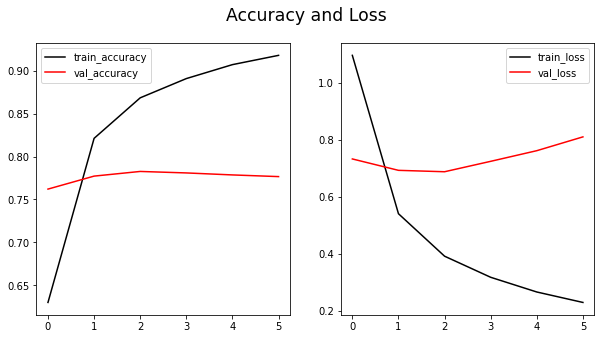

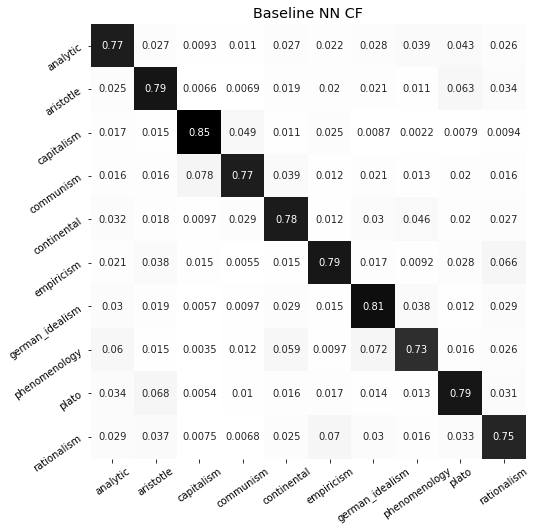




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.83      0.77      0.80     13292
           1       0.83      0.79      0.81     12254
           2       0.81      0.85      0.83      4573
           3       0.77      0.77      0.77      4559
           4       0.77      0.78      0.77      8246
           5       0.71      0.79      0.75      5085
           6       0.81      0.81      0.81     10330
           7       0.75      0.73      0.74      7243
           8       0.78      0.79      0.78      9668
           9       0.66      0.75      0.70      5734

    accuracy                           0.78     80984
   macro avg       0.77      0.78      0.78     80984
weighted avg       0.78      0.78      0.78     80984



In [25]:
summarize_model(history, test, preds, labels=flipped_dict, title='Baseline NN CF')

Seems good, though it did overfit towards the end. The flat accuracy curve seems to indicate that training did not actually help the model much at all, actually. 

Still, neural nets seem like they might be the way to go - let's try some options out!



### Hyperparameter Tuning

#### Try Using RMSprop instead of Adam

In [28]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450, 
                                                                                     tokenizer_name='rmsprop_tokenizer.pkl')

def make_model(embedding_size = 256):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50,return_sequences=False))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    display(model.summary())
    return model


model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         21700096  
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                61400     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
Total params: 21,762,006
Trainable params: 21,762,006
Non-trainable params: 0
_________________________________________________________________


None

In [30]:
RMSprop_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
760/760 [==============================] - 89s 117ms/step - loss: 1.0878 - accuracy: 0.6362 - val_loss: 0.8396 - val_accuracy: 0.7295
Epoch 2/10
760/760 [==============================] - 89s 117ms/step - loss: 0.6576 - accuracy: 0.7841 - val_loss: 0.7191 - val_accuracy: 0.7668
Epoch 3/10
760/760 [==============================] - 89s 117ms/step - loss: 0.5595 - accuracy: 0.8152 - val_loss: 0.6943 - val_accuracy: 0.7736
Epoch 4/10
760/760 [==============================] - 89s 117ms/step - loss: 0.5070 - accuracy: 0.8318 - val_loss: 0.7077 - val_accuracy: 0.7733
Epoch 5/10
760/760 [==============================] - 89s 117ms/step - loss: 0.4674 - accuracy: 0.8446 - val_loss: 0.6685 - val_accuracy: 0.7850
Epoch 6/10
760/760 [==============================] - 89s 117ms/step - loss: 0.4338 - accuracy: 0.8554 - val_loss: 0.7042 - val_accuracy: 0.7753
Epoch 7/10
760/760 [==============================] - 89s 117ms/step - loss: 0.4032 - accuracy: 0.8651 - val_loss: 0.6598 - val_ac

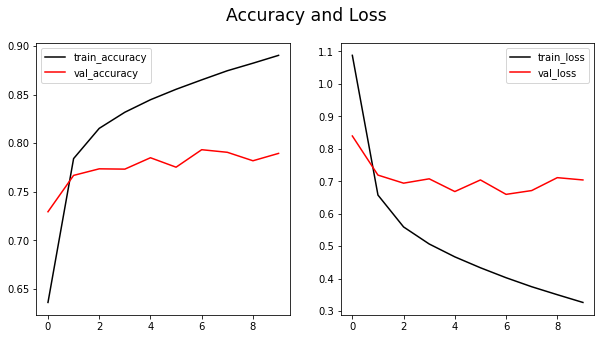

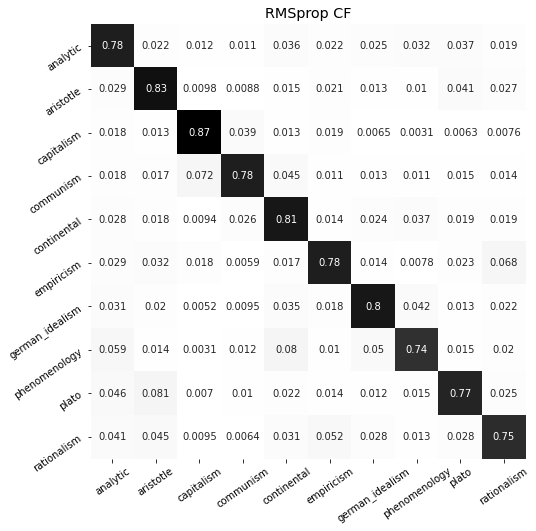




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.82      0.78      0.80     13361
           1       0.83      0.83      0.83     12274
           2       0.81      0.87      0.84      4585
           3       0.78      0.78      0.78      4443
           4       0.75      0.81      0.78      8500
           5       0.73      0.78      0.75      5113
           6       0.85      0.80      0.82     10255
           7       0.76      0.74      0.75      7052
           8       0.81      0.77      0.79      9590
           9       0.71      0.75      0.72      5811

    accuracy                           0.79     80984
   macro avg       0.78      0.79      0.79     80984
weighted avg       0.79      0.79      0.79     80984



In [32]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(RMSprop_history, test, preds, labels=flipped_dict, title='RMSprop CF')

This looks pretty good, in fact it's the best one yet at 79.3% accuracy over 10 classes. We have some of the same issues with not learning as much, but it did seem to do a bit better than Adam. 

Let's try GRU instead of LSTM next. 

#### Try Using GRU instead of LSTM

In [34]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450, 
                                                                                     tokenizer_name='gru_tokenizer.pkl')

# Trying out GRU
def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(GRU(50, return_sequences=False))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         10850176  
_________________________________________________________________
gru (GRU)                    (None, 50)                27000     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
Total params: 10,877,686
Trainable params: 10,877,686
Non-trainable params: 0
_________________________________________________________________


None

In [35]:
GRU_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
760/760 [==============================] - 60s 77ms/step - loss: 1.7265 - accuracy: 0.3708 - val_loss: 1.0003 - val_accuracy: 0.6675
Epoch 2/10
760/760 [==============================] - 62s 81ms/step - loss: 0.8673 - accuracy: 0.7146 - val_loss: 0.7826 - val_accuracy: 0.7472
Epoch 3/10
760/760 [==============================] - 62s 81ms/step - loss: 0.6557 - accuracy: 0.7867 - val_loss: 0.6976 - val_accuracy: 0.7748
Epoch 4/10
760/760 [==============================] - 62s 81ms/step - loss: 0.5568 - accuracy: 0.8191 - val_loss: 0.6797 - val_accuracy: 0.7780
Epoch 5/10
760/760 [==============================] - 62s 81ms/step - loss: 0.5016 - accuracy: 0.8360 - val_loss: 0.6707 - val_accuracy: 0.7829
Epoch 6/10
760/760 [==============================] - 62s 81ms/step - loss: 0.4559 - accuracy: 0.8488 - val_loss: 0.6499 - val_accuracy: 0.7906
Epoch 7/10
760/760 [==============================] - 62s 81ms/step - loss: 0.4258 - accuracy: 0.8588 - val_loss: 0.6596 - val_accuracy:

GRU seems to be not appreciably different than LSTM on this task.



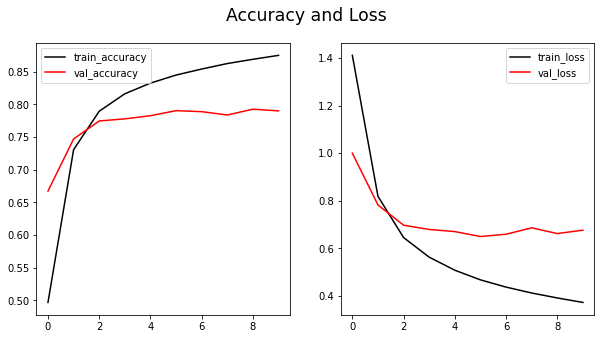

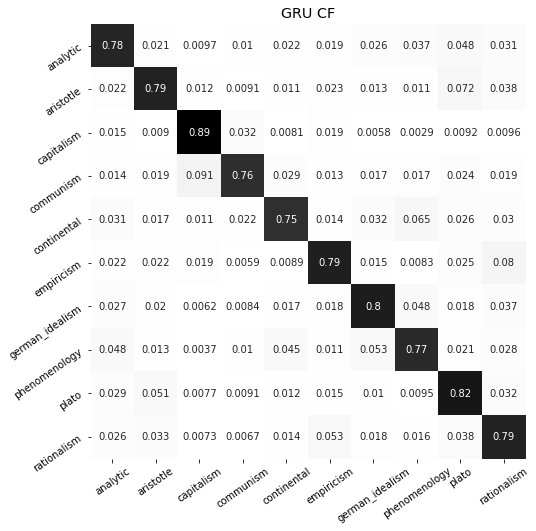




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.85      0.78      0.81     13560
           1       0.85      0.79      0.82     12139
           2       0.79      0.89      0.84      4465
           3       0.79      0.76      0.77      4509
           4       0.83      0.75      0.79      8447
           5       0.73      0.79      0.76      5044
           6       0.84      0.80      0.82     10372
           7       0.73      0.77      0.75      7117
           8       0.75      0.82      0.79      9552
           9       0.64      0.79      0.71      5779

    accuracy                           0.79     80984
   macro avg       0.78      0.79      0.79     80984
weighted avg       0.80      0.79      0.79     80984



In [36]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(GRU_history, test, preds, labels=flipped_dict, title='GRU CF')

79% accuracy, as before, and with the same tendency to stop learning quite quickly. Still, it does learn better than adam version we have run in the past. 

#### Bidirectional LSTM

In [39]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, 
                                                                                     tokenizer_name='bidirectional_tokenizer.pkl')

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(Bidirectional(LSTM(50,return_sequences=False)))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    display(model.summary())
    return model


model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         10826240  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               71600     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 10,898,850
Trainable params: 10,898,850
Non-trainable params: 0
_________________________________________________________________


None

In [40]:
bidirectional_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
760/760 [==============================] - 86s 110ms/step - loss: 1.6735 - accuracy: 0.4070 - val_loss: 0.8898 - val_accuracy: 0.7099
Epoch 2/10
760/760 [==============================] - 83s 109ms/step - loss: 0.7548 - accuracy: 0.7546 - val_loss: 0.8741 - val_accuracy: 0.7155
Epoch 3/10
760/760 [==============================] - 83s 110ms/step - loss: 0.5988 - accuracy: 0.8035 - val_loss: 0.7246 - val_accuracy: 0.7642
Epoch 4/10
760/760 [==============================] - 83s 110ms/step - loss: 0.5327 - accuracy: 0.8248 - val_loss: 0.6917 - val_accuracy: 0.7788
Epoch 5/10
760/760 [==============================] - 83s 110ms/step - loss: 0.4848 - accuracy: 0.8395 - val_loss: 0.6792 - val_accuracy: 0.7815
Epoch 6/10
760/760 [==============================] - 82s 108ms/step - loss: 0.4587 - accuracy: 0.8485 - val_loss: 0.7087 - val_accuracy: 0.7728
Epoch 7/10
760/760 [==============================] - 83s 109ms/step - loss: 0.4329 - accuracy: 0.8565 - val_loss: 0.6659 - val_ac

Looks good, more or less on par with the baseline unidirectional LSTM. 

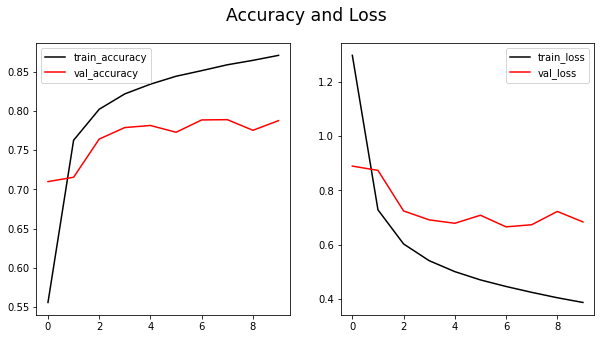

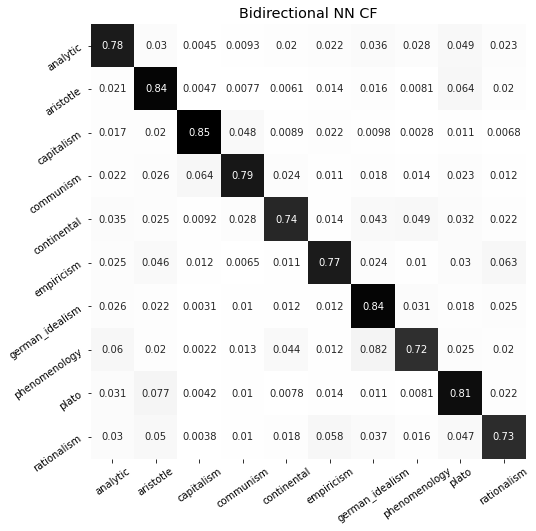




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.84      0.78      0.81     13342
           1       0.81      0.84      0.82     12145
           2       0.86      0.85      0.86      4583
           3       0.77      0.79      0.78      4534
           4       0.84      0.74      0.79      8512
           5       0.73      0.77      0.75      5072
           6       0.80      0.84      0.82     10250
           7       0.77      0.72      0.75      7154
           8       0.75      0.81      0.78      9606
           9       0.71      0.73      0.72      5786

    accuracy                           0.79     80984
   macro avg       0.79      0.79      0.79     80984
weighted avg       0.79      0.79      0.79     80984



In [41]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(bidirectional_history, test, preds, labels=flipped_dict, title='Bidirectional NN CF')

This printout could be the one we saw before. Still some overtraining - we probably don't need all 10 epochs. 

#### Multiple LSTM Layers 

Next, let's try training a model with multiple LSTM layers to see if that improves performance.

In [42]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, 
                                                                                     tokenizer_name='multi_lstm_tokenizer.pkl')

# commented out layers indicate past attempts
# none were particularly successful
def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 128)         10837504  
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 50)          35800     
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                510       
Total params: 10,894,014
Trainable params: 10,894,014
Non-trainable params: 0
_________________________________________________________________


None

In [43]:
multi_LSTM_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
760/760 [==============================] - 79s 101ms/step - loss: 1.6045 - accuracy: 0.4129 - val_loss: 0.9761 - val_accuracy: 0.6780
Epoch 2/10
760/760 [==============================] - 76s 100ms/step - loss: 0.8234 - accuracy: 0.7279 - val_loss: 0.7972 - val_accuracy: 0.7393
Epoch 3/10
760/760 [==============================] - 77s 101ms/step - loss: 0.6314 - accuracy: 0.7926 - val_loss: 0.7064 - val_accuracy: 0.7704
Epoch 4/10
760/760 [==============================] - 77s 101ms/step - loss: 0.5506 - accuracy: 0.8186 - val_loss: 0.7112 - val_accuracy: 0.7707
Epoch 5/10
760/760 [==============================] - 77s 102ms/step - loss: 0.4963 - accuracy: 0.8358 - val_loss: 0.7250 - val_accuracy: 0.7707
Epoch 6/10
760/760 [==============================] - 77s 101ms/step - loss: 0.4602 - accuracy: 0.8465 - val_loss: 0.6775 - val_accuracy: 0.7845
Epoch 7/10
760/760 [==============================] - 77s 101ms/step - loss: 0.4301 - accuracy: 0.8570 - val_loss: 0.7191 - val_ac

Similar result again. It doesn't seem like more layers of LSTM is what we need to improve results.

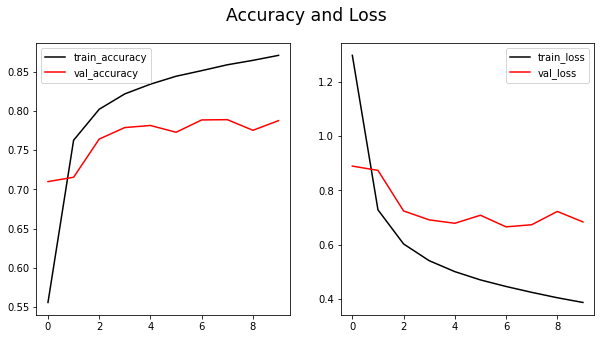

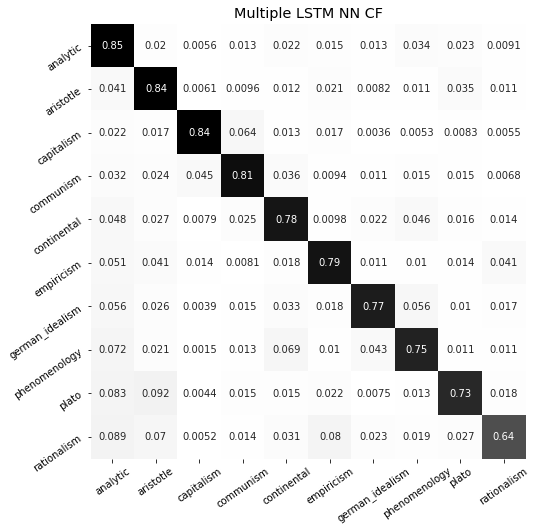




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.75      0.85      0.79     13341
           1       0.80      0.84      0.82     12087
           2       0.87      0.84      0.86      4717
           3       0.74      0.81      0.77      4565
           4       0.78      0.78      0.78      8470
           5       0.71      0.79      0.75      5048
           6       0.88      0.77      0.82     10346
           7       0.73      0.75      0.74      7129
           8       0.84      0.73      0.78      9549
           9       0.78      0.64      0.70      5732

    accuracy                           0.79     80984
   macro avg       0.79      0.78      0.78     80984
weighted avg       0.79      0.79      0.79     80984



In [44]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(bidirectional_history, test, preds, labels=flipped_dict, title='Multiple LSTM NN CF')

More or less the same as past models. More layers don't seem to hurt (except when it comes to training time), but they don't seem to help much either. 

#### More LSTM Neurons

In [47]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y,
                                                                                     tokenizer_name='extra_lstm_nn_tokenizer.pkl')

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(100, return_sequences=False))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 128)         10851968  
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1010      
Total params: 10,944,578
Trainable params: 10,944,578
Non-trainable params: 0
_________________________________________________________________


None

In [48]:
extra_LSTM_neurons_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=set_early_stop(),
                                  class_weight=weights_dict)

Epoch 1/10
760/760 [==============================] - 62s 79ms/step - loss: 1.5988 - accuracy: 0.4426 - val_loss: 0.8779 - val_accuracy: 0.7139
Epoch 2/10
760/760 [==============================] - 60s 79ms/step - loss: 0.7084 - accuracy: 0.7679 - val_loss: 0.7847 - val_accuracy: 0.7415
Epoch 3/10
760/760 [==============================] - 60s 79ms/step - loss: 0.5784 - accuracy: 0.8090 - val_loss: 0.6780 - val_accuracy: 0.7782
Epoch 4/10
760/760 [==============================] - 60s 78ms/step - loss: 0.5141 - accuracy: 0.8285 - val_loss: 0.6942 - val_accuracy: 0.7781
Epoch 5/10
760/760 [==============================] - 60s 79ms/step - loss: 0.4738 - accuracy: 0.8419 - val_loss: 0.6727 - val_accuracy: 0.7827
Epoch 6/10
760/760 [==============================] - 60s 79ms/step - loss: 0.4475 - accuracy: 0.8514 - val_loss: 0.6833 - val_accuracy: 0.7828
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping


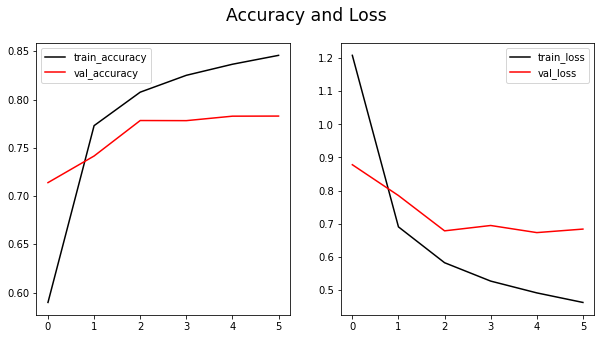

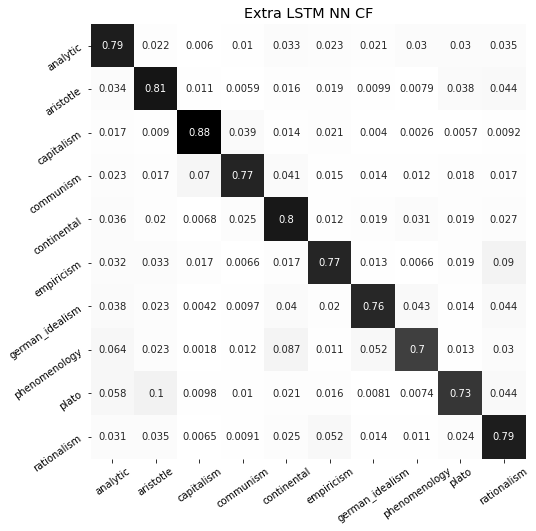




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.80      0.79      0.80     13401
           1       0.81      0.81      0.81     12273
           2       0.82      0.88      0.85      4542
           3       0.78      0.77      0.78      4444
           4       0.74      0.80      0.77      8511
           5       0.72      0.77      0.74      5119
           6       0.87      0.76      0.81     10342
           7       0.78      0.70      0.74      7075
           8       0.81      0.73      0.77      9558
           9       0.61      0.79      0.69      5719

    accuracy                           0.78     80984
   macro avg       0.77      0.78      0.78     80984
weighted avg       0.79      0.78      0.78     80984



In [49]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(extra_LSTM_neurons_history, test, preds, labels=flipped_dict, title='Extra LSTM NN CF')

This actually seems to have gotten mildly worse. Let's see if adding a dense layer changes anything.

#### Adding Dense Layers

In [50]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450,
                                                                                     tokenizer_name='extra_dense_tokenizer.pkl')

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 128)         10786176  
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_8 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)               

None

In [51]:
extra_dense_history = model.fit(x_train_seq, y_train_seq, epochs=20,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/20
760/760 [==============================] - 77s 98ms/step - loss: 2.0247 - accuracy: 0.2188 - val_loss: 1.3810 - val_accuracy: 0.5112
Epoch 2/20
760/760 [==============================] - 75s 98ms/step - loss: 1.3637 - accuracy: 0.4714 - val_loss: 1.1584 - val_accuracy: 0.6304
Epoch 3/20
760/760 [==============================] - 74s 98ms/step - loss: 1.1626 - accuracy: 0.5797 - val_loss: 1.0159 - val_accuracy: 0.6973
Epoch 4/20
760/760 [==============================] - 73s 96ms/step - loss: 1.0393 - accuracy: 0.6445 - val_loss: 0.9754 - val_accuracy: 0.7190
Epoch 5/20
760/760 [==============================] - 73s 97ms/step - loss: 0.9380 - accuracy: 0.6914 - val_loss: 0.9943 - val_accuracy: 0.7249
Epoch 6/20
760/760 [==============================] - 75s 98ms/step - loss: 0.8644 - accuracy: 0.7217 - val_loss: 0.9709 - val_accuracy: 0.7345
Epoch 7/20
760/760 [==============================] - 74s 97ms/step - loss: 0.7976 - accuracy: 0.7443 - val_loss: 0.9699 - val_accuracy:

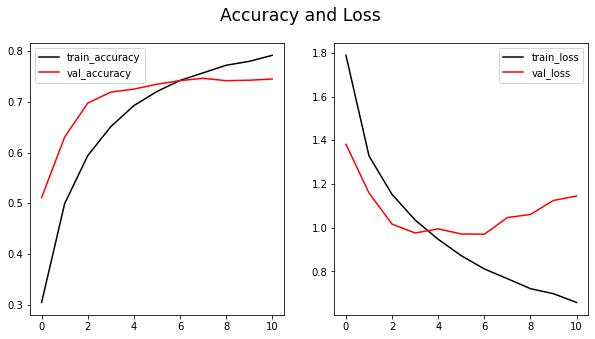

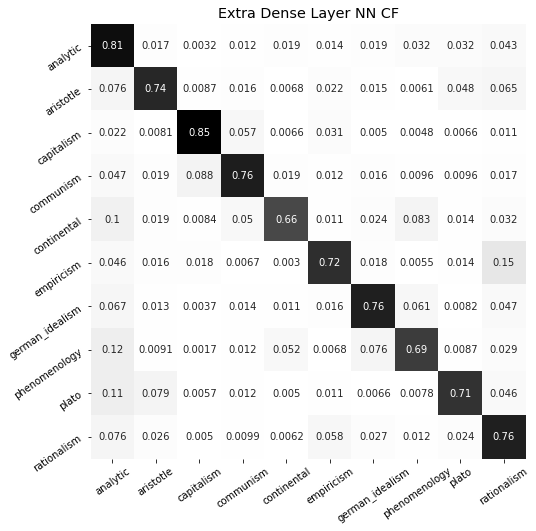




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.67      0.81      0.73     13369
           1       0.84      0.74      0.79     12137
           2       0.82      0.85      0.83      4558
           3       0.70      0.76      0.73      4474
           4       0.84      0.66      0.74      8568
           5       0.73      0.72      0.72      5072
           6       0.83      0.76      0.79     10410
           7       0.70      0.69      0.70      7248
           8       0.81      0.71      0.76      9516
           9       0.54      0.76      0.63      5632

    accuracy                           0.74     80984
   macro avg       0.75      0.74      0.74     80984
weighted avg       0.76      0.74      0.75     80984



In [52]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(extra_dense_history, test, preds, labels=flipped_dict, title='Extra Dense Layer NN CF')

This one actually seemed to do worse than most of the other models. A dense layer doesn't seem to improve performance. 

#### Batch Size Changes

First, the baseline model but with double the batch size.

In [53]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450,
                                                                                     tokenizer_name='big_batch_size.pkl.')

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 128)         10807936  
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                510       
Total params: 10,844,246
Trainable params: 10,844,246
Non-trainable params: 0
_________________________________________________________________


None

In [54]:
more_batches_LSTM_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=512, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
380/380 [==============================] - 43s 110ms/step - loss: 1.8099 - accuracy: 0.3293 - val_loss: 1.0600 - val_accuracy: 0.6497
Epoch 2/10
380/380 [==============================] - 41s 109ms/step - loss: 0.8728 - accuracy: 0.7162 - val_loss: 0.7968 - val_accuracy: 0.7434
Epoch 3/10
380/380 [==============================] - 41s 109ms/step - loss: 0.6338 - accuracy: 0.7933 - val_loss: 0.7215 - val_accuracy: 0.7661
Epoch 4/10
380/380 [==============================] - 41s 108ms/step - loss: 0.5422 - accuracy: 0.8217 - val_loss: 0.6908 - val_accuracy: 0.7785
Epoch 5/10
380/380 [==============================] - 41s 108ms/step - loss: 0.4812 - accuracy: 0.8417 - val_loss: 0.6677 - val_accuracy: 0.7863
Epoch 6/10
380/380 [==============================] - 41s 108ms/step - loss: 0.4433 - accuracy: 0.8529 - val_loss: 0.6632 - val_accuracy: 0.7874
Epoch 7/10
380/380 [==============================] - 41s 109ms/step - loss: 0.4154 - accuracy: 0.8609 - val_loss: 0.7101 - val_ac

Not any real improvement here.

Next let's try the same but with a smaller batch size.

In [55]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450)

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 128)         10842240  
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                35800     
_________________________________________________________________
dense_12 (Dense)             (None, 10)                510       
Total params: 10,878,550
Trainable params: 10,878,550
Non-trainable params: 0
_________________________________________________________________


None

In [56]:
more_batches_more_dense_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=32, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
6074/6074 [==============================] - 236s 39ms/step - loss: 1.3883 - accuracy: 0.5205 - val_loss: 0.8121 - val_accuracy: 0.7374
Epoch 2/10
6074/6074 [==============================] - 234s 39ms/step - loss: 0.7079 - accuracy: 0.7694 - val_loss: 0.7109 - val_accuracy: 0.7733
Epoch 3/10
6074/6074 [==============================] - 237s 39ms/step - loss: 0.5963 - accuracy: 0.8072 - val_loss: 0.6900 - val_accuracy: 0.7777
Epoch 4/10
6074/6074 [==============================] - 258s 42ms/step - loss: 0.5433 - accuracy: 0.8242 - val_loss: 0.6742 - val_accuracy: 0.7849
Epoch 5/10
6074/6074 [==============================] - 258s 42ms/step - loss: 0.5072 - accuracy: 0.8338 - val_loss: 0.6801 - val_accuracy: 0.7844
Epoch 6/10
6074/6074 [==============================] - 254s 42ms/step - loss: 0.4824 - accuracy: 0.8423 - val_loss: 0.6669 - val_accuracy: 0.7878
Epoch 7/10
6074/6074 [==============================] - 238s 39ms/step - loss: 0.4570 - accuracy: 0.8511 - val_loss: 0

Not much luck there either. Now we get extra experimental.

#### A Bit of Everything!

In [ ]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450)

# two dense layers, an LSTM layer, and a bi-directional layer!
def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50, return_sequences=True))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Bidirectional(LSTM(50,return_sequences=False)))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         10850176  
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 50)          35800     
_________________________________________________________________
dense_10 (Dense)             (None, None, 25)          1275      
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 25)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               30400     
_________________________________________________________________
dense_11 (Dense)             (None, 25)                2525      
_________________________________________________________________
dropout_6 (Dropout)          (None, 25)               

None

In [ ]:
LSTM_bi_dense_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=512, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
380/380 [==============================] - 96s 237ms/step - loss: 2.0263 - accuracy: 0.2269 - val_loss: 1.2184 - val_accuracy: 0.5927
Epoch 2/10
115/380 [========>.....................] - ETA: 57s - loss: 1.2279 - accuracy: 0.5676

KeyboardInterrupt: ignored

In [ ]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(LSTM_bi_dense_history, test, preds, labels=flipped_dict, title='LSTM 2 Dense & Bi-Directional NN CF')

These results were again in the range of the rest. At this point it's clear that we can achieve about 75% accuracy with most types of models; we're looking for something that can jump us up to 80% or more.

Let's try extra dense layers, this time with three of them. 

In [ ]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450)

# three dense layers on top of an LSTM layer
def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(75, return_sequences=False))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         10071296  
_________________________________________________________________
lstm_5 (LSTM)                (None, 75)                61200     
_________________________________________________________________
dense_11 (Dense)             (None, 25)                1900      
_________________________________________________________________
dropout_7 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_8 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 25)               

None

In [ ]:
# extra epochs since the last extra dense layer model seemed to improve for longer
triple_dense_history = model.fit(x_train_seq, y_train_seq, epochs=20,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/20
767/767 [==============================] - 81s 104ms/step - loss: 2.0810 - accuracy: 0.1759 - val_loss: 1.5213 - val_accuracy: 0.3865
Epoch 2/20
767/767 [==============================] - 79s 104ms/step - loss: 1.4841 - accuracy: 0.3999 - val_loss: 1.2963 - val_accuracy: 0.5482
Epoch 3/20
767/767 [==============================] - 79s 103ms/step - loss: 1.2211 - accuracy: 0.5440 - val_loss: 1.1543 - val_accuracy: 0.6236
Epoch 4/20
767/767 [==============================] - 79s 104ms/step - loss: 1.0307 - accuracy: 0.6314 - val_loss: 1.0632 - val_accuracy: 0.6637
Epoch 5/20
767/767 [==============================] - 79s 103ms/step - loss: 0.9208 - accuracy: 0.6763 - val_loss: 1.0657 - val_accuracy: 0.6821
Epoch 6/20
767/767 [==============================] - 79s 103ms/step - loss: 0.8335 - accuracy: 0.7142 - val_loss: 1.0767 - val_accuracy: 0.6851
Epoch 7/20
767/767 [==============================] - 79s 103ms/step - loss: 0.7566 - accuracy: 0.7448 - val_loss: 1.1155 - val_ac

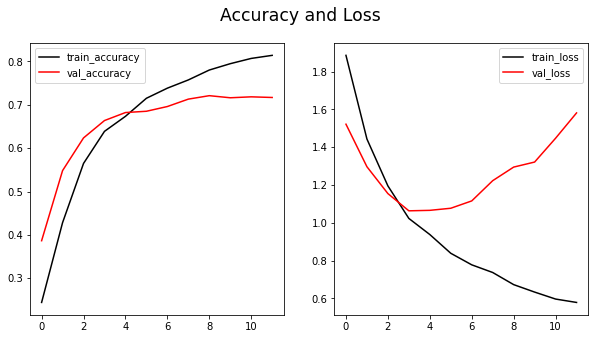

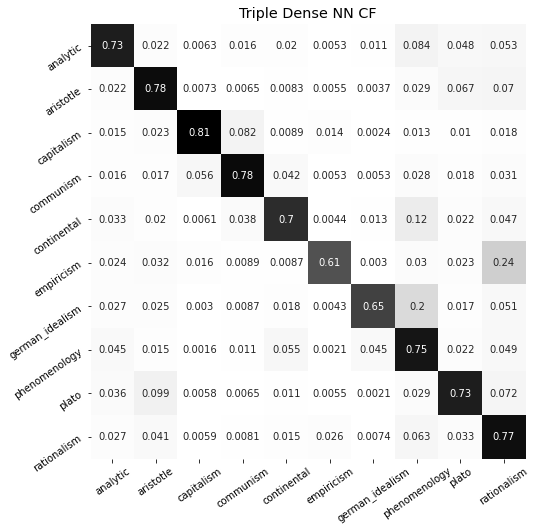




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.84      0.73      0.78     13320
           1       0.81      0.78      0.79     12613
           2       0.84      0.81      0.83      4608
           3       0.73      0.78      0.75      4504
           4       0.81      0.70      0.75      8566
           5       0.85      0.61      0.71      5061
           6       0.90      0.65      0.75     10642
           7       0.49      0.75      0.59      7095
           8       0.74      0.73      0.74      9625
           9       0.47      0.77      0.58      5778

    accuracy                           0.73     81812
   macro avg       0.75      0.73      0.73     81812
weighted avg       0.77      0.73      0.74     81812



In [ ]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(triple_dense_history, test, preds, labels=flipped_dict, title='Triple Dense NN CF')

Not particularly inspiring, in fact this is worse than just two dense layers. 

We've tried a decent number of options here. Next let's see what happens if we bring in word embeddings from GloVe.

### Using Glove Word Embeddings

In [16]:
glove_file = datapath('/gdrive/MyDrive/Colab_Projects/Phil_NLP/glove.6B.300d.txt')
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file)

glove_vectors = KeyedVectors.load_word2vec_format(tmp_file)

In [17]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450, tokenizer_name='glove_tokenizer.pkl')

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(glove_vectors.get_keras_embedding())
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          20000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                260       
Total params: 20,021,735
Trainable params: 21,735
Non-trainable params: 20,000,000
_________________________________________________________________


None

In [18]:
glove_embeddings_LSTM_history = model.fit(x_train_seq, y_train_seq, epochs=20,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/20
760/760 [==============================] - 29s 35ms/step - loss: 2.2821 - accuracy: 0.1223 - val_loss: 2.1441 - val_accuracy: 0.2018
Epoch 2/20
760/760 [==============================] - 26s 35ms/step - loss: 2.1268 - accuracy: 0.1965 - val_loss: 2.0020 - val_accuracy: 0.2669
Epoch 3/20
760/760 [==============================] - 26s 35ms/step - loss: 2.0006 - accuracy: 0.2497 - val_loss: 1.9337 - val_accuracy: 0.2933
Epoch 4/20
760/760 [==============================] - 26s 35ms/step - loss: 1.9280 - accuracy: 0.2780 - val_loss: 1.8772 - val_accuracy: 0.3182
Epoch 5/20
760/760 [==============================] - 26s 35ms/step - loss: 1.8686 - accuracy: 0.3038 - val_loss: 1.8371 - val_accuracy: 0.3232
Epoch 6/20
760/760 [==============================] - 26s 34ms/step - loss: 1.8166 - accuracy: 0.3210 - val_loss: 1.7941 - val_accuracy: 0.3459
Epoch 7/20
760/760 [==============================] - 26s 35ms/step - loss: 1.7888 - accuracy: 0.3332 - val_loss: 1.7685 - val_accuracy:

Not very promising - perhaps the vectors that worked from GloVe and were trained on our data would be better?

### Custom Word Embeddings

In [19]:
custom_vectors = KeyedVectors.load('/gdrive/MyDrive/Colab_Projects/Phil_NLP/w2v_models/w2v_for_nn.wordvectors')

In [22]:
custom_vectors.most_similar('philosophy')

[('metaphysics', 0.7894171476364136),
 ('theology', 0.7694715261459351),
 ('religion', 0.7320282459259033),
 ('science', 0.728236734867096),
 ('philosophical', 0.7186429500579834),
 ('transcendental philosophy', 0.7153382301330566),
 ('natural science', 0.7118123769760132),
 ('psychology', 0.7090511322021484),
 ('politics', 0.6923774480819702),
 ('skepticism', 0.6838987469673157)]

In [29]:
tokenizer, x_train_seqx_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450, tokenizer_name='custom_w2v_tokenizer.pkl')

def make_model(embedding_size = 256):
    model=Sequential()

    model.add(custom_vectors.get_keras_embedding())
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         8499300   
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                70200     
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                260       
Total params: 8,571,035
Trainable params: 71,735
Non-trainable params: 8,499,300
_________________________________________________________________


None

In [30]:
len(tokenizer.word_index)

84765

In [31]:
len(custom_vectors.vocab)

28331

In [32]:
custom_embeddings_LSTM_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10


InvalidArgumentError: ignored

Sadly, the embeddings we trained on our data (and on GloVe) seem to hinder more than they help.

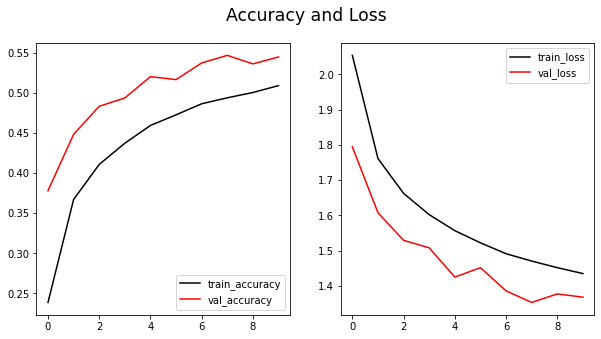

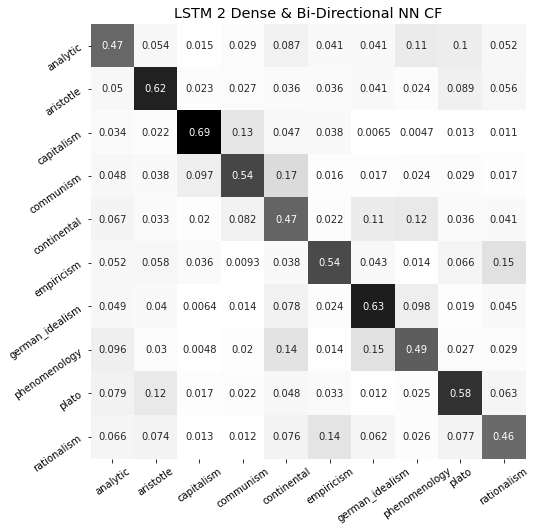




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.60      0.47      0.52     13403
           1       0.68      0.62      0.65     12702
           2       0.66      0.69      0.68      4640
           3       0.49      0.54      0.51      4601
           4       0.42      0.47      0.44      8329
           5       0.48      0.54      0.51      5062
           6       0.63      0.63      0.63     10554
           7       0.44      0.49      0.47      7140
           8       0.57      0.58      0.58      9659
           9       0.40      0.46      0.43      5722

    accuracy                           0.55     81812
   macro avg       0.54      0.55      0.54     81812
weighted avg       0.56      0.55      0.55     81812



In [ ]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(custom_embeddings_LSTM_history, test, preds, labels=flipped_dict, title='Custom Embeddings LSTM NN CF')

In [ ]:
Word2Vec.load('/gdrive/MyDrive/Colab_Projects/Phil_NLP/w2v_for_nn2.bin')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


AttributeError: ignored

In [ ]:
print(classification_report(test, preds))

              precision    recall  f1-score   support

           0       0.81      0.76      0.78     13274
           1       0.82      0.78      0.80     12774
           2       0.83      0.80      0.81      4536
           3       0.69      0.79      0.73      4451
           4       0.80      0.74      0.77      8466
           5       0.71      0.77      0.74      5152
           6       0.83      0.77      0.80     10554
           7       0.70      0.75      0.72      7159
           8       0.71      0.80      0.75      9589
           9       0.68      0.71      0.70      5857

    accuracy                           0.77     81812
   macro avg       0.76      0.77      0.76     81812
weighted avg       0.77      0.77      0.77     81812



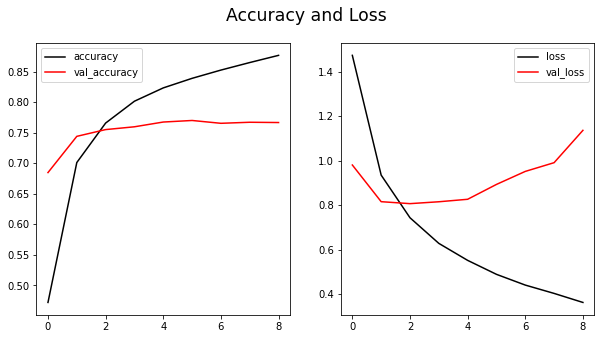

In [ ]:
def show_curves_nn(model):
  history_df = pd.DataFrame(model.history)
  fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,5))
  fig.suptitle('Accuracy and Loss', fontsize='xx-large')
  ax1.plot(history_df['accuracy'], label='accuracy', color='black')
  ax1.plot(history_df['val_accuracy'], label='val_accuracy', color='red')
  legend = ax1.legend()
  ax2.plot(history_df['loss'], label='loss', color='black')
  ax2.plot(history_df['val_loss'], label='val_loss', color='red')
  legend = ax2.legend()

show_curves_nn(history)

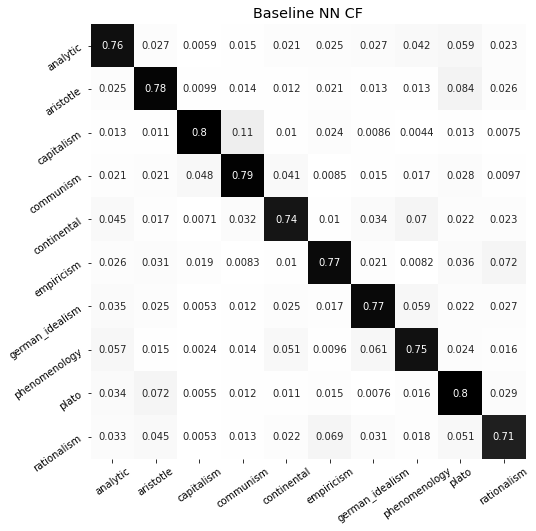

In [ ]:
plot_pretty_nn_cf(test, preds, label_dict=flipped_dict, title='Baseline NN CF')

In [ ]:
def plot_pretty_nn_cf(test_labels, predicted_labels, cmap='Greys', label_dict={}, title='CF'):
  fig, ax = plt.subplots(figsize=(8,8))
  cm = confusion_matrix(test_labels, predicted_labels)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  ax = sns.heatmap(cm, cmap=cmap, annot=True, cbar=False, square=True)
  if label_dict != {}:
    ax.set_xticklabels([label_dict[int(x.get_text())] for x in ax.get_xticklabels()], rotation=35)
    ax.set_yticklabels([label_dict[int(x.get_text())] for x in ax.get_yticklabels()], rotation=35)
  ax.set_title(title, fontsize='x-large')
  plt.show()